# Trajectory Recommendation

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#sec1)
  1. [Load Data](#sec1.1)
  1. [Utility function](#sec1.2)
1. [POI Ranking](#sec2)
  1. [POI Features for Ranking](#sec2.1)
  1. [Training DataFrame](#sec2.2)
  1. [Test DataFrame](#sec2.3)
  1. [Ranking POIs using rankSVM](#sec2.4)
  1. [Recommendation based on POI Ranking](#sec2.5)
1. [Factorise Transition Probabilities in POI Feature Space](#sec3)
  1. [POI Features for Factorisation](#sec3.1)
  1. [Transition Matrix between POI Cateogries](#sec3.2)
  1. [Transition Matrix between POI Popularity Classes](#sec3.3)
  1. [Transition Matrix between the Number of POI Visit Classes](#sec3.4)
  1. [Transition Matrix between POI Average Visit Duration Classes](#sec3.5)
  1. [Transition Matrix between POI Neighborhood Classes](#sec3.6)
  1. [Transition Matrix between POIs](#sec3.7)
  1. [Recommendation based on POI Transition Matrix](#sec3.8)
1. [Combine POI Ranking with Factorised Markov Chain](#sec4)
1. [Comparison](#sec5)

<a id='sec1'></a>

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy.linalg import kron
from scipy.misc import logsumexp
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
import seaborn as sns
import pulp

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-recsys16'
suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']

In [4]:
dat_ix = 1

In [5]:
datasettypes = ['all', 'noshort', 'perfect']

In [6]:
dstype = datasettypes[2]

Hyperparameters.

In [7]:
uspecific = True
KX = 100  # 100 folds in user specific setting
kxstr = str(KX) + 'X-'

In [8]:
ALPHA = 0.5
alphastr = str(ALPHA).replace('.', '_') + '-'

Method switches.

In [9]:
run_rank = True
run_tran = True
run_comb = True

In [10]:
fpoi = os.path.join(data_dir, 'poi-' + suffix[dat_ix] + '.csv')

In [11]:
ftraj = os.path.join(data_dir, 'traj-' + dstype + '-' + suffix[dat_ix] + '.csv')

Files to store results.

In [12]:
if uspecific == True:
    frecdict_rank = os.path.join(data_dir, 'rank-' + dstype + '-specific-' + kxstr + suffix[dat_ix] + '.pkl')
    frecdict_tran = os.path.join(data_dir, 'tran-' + dstype + '-specific-' + kxstr + suffix[dat_ix] + '.pkl')
    frecdict_comb = os.path.join(data_dir, 'comb-' + dstype + '-specific-' + alphastr + kxstr + suffix[dat_ix] + '.pkl')
else:
    frecdict_rank = os.path.join(data_dir, 'rank-' + dstype + '-agnostic-' + suffix[dat_ix] + '.pkl')
    frecdict_tran = os.path.join(data_dir, 'tran-' + dstype + '-agnostic-' + suffix[dat_ix] + '.pkl')
    frecdict_comb = os.path.join(data_dir, 'comb-' + dstype + '-agnostic-' + alphastr + suffix[dat_ix] + '.pkl')

<a id='sec1.1'></a>

## 1.1 Load Data

In [13]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,#photo,endTime,poiID,startTime,trajID,trajLen,userID,poiDuration
0,5,1308366396,13,1308361705,38,3,11037560@N04,4691
1,1,1308369674,21,1308369674,38,3,11037560@N04,0
2,2,1308376173,2,1308376102,38,3,11037560@N04,71
3,2,1308461617,2,1308454575,39,3,11037560@N04,7042
4,1,1308462069,21,1308462069,39,3,11037560@N04,0


In [14]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Transport,-4.258101,55.857920
2,Transport,-4.250728,55.861496
4,Transport,-4.595632,55.509388
5,Transport,-4.331517,55.868897
6,Transport,-4.269905,55.856135


In [15]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
#assert(num_poi == poi_all.shape[0])
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Glas,23,75,1.136364,66


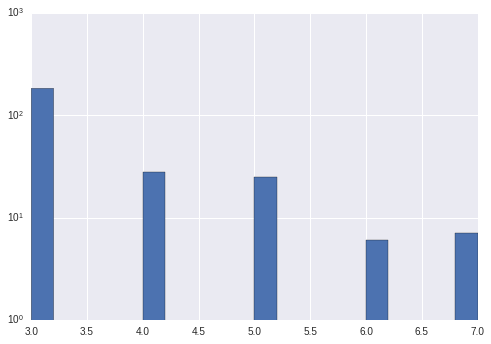

In [16]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')

Mapping trajectory to user.

In [17]:
traj_user = traj_all[['trajID', 'userID']].copy().groupby('trajID').first()
traj_user.head()

,userID
trajID,
38,11037560@N04
39,11037560@N04
55,11452054@N00
107,14086506@N02
119,14578360@N00


<a id='sec1.2'></a>

## 1.2 Utility function

Print computing progress.

In [18]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [19]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [20]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [21]:
def calc_F1(seq_act, seq_rec):
    '''Compute recall, precision and F1 when trajectories contain sub-tours'''
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    #actset = set(seq_act)
    #recset = set(seq_rec)
    #intersect = actset & recset
    
    match_tags = np.zeros(len(seq_act), dtype=np.bool)
    for poi in seq_rec:
        for j in range(len(seq_act)):
            if match_tags[j] == False and poi == seq_act[j]:
                match_tags[j] = True
                break
    intersize = np.nonzero(match_tags)[0].shape[0]
    recall = intersize / len(seq_act)
    precision = intersize / len(seq_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [22]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.0088 # mean earth radius is 6371.0088km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [23]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [24]:
query_id_dict = dict()  # (start, end, length) --> qid

In [25]:
trajs = [extract_traj(tid, traj_all) for tid in trajid_set_all]
keys = [(t[0], t[-1], len(t)) for t in trajs if len(t) > 2]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

In [26]:
poi_info_ = calc_poi_info(trajid_set_all, traj_all, poi_all)
poi_info_.head()

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
1,1793.450000,20,Transport,-4.258101,55.857920,20
2,858.189189,37,Transport,-4.250728,55.861496,36
5,0.000000,1,Transport,-4.331517,55.868897,1
6,0.000000,2,Transport,-4.269905,55.856135,2
8,2628.000000,1,Education,-4.249762,55.867072,1


In [27]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(query_id_dict))

#traj in total: 75
#traj (length > 2): 75
#query tuple: 66


<a id='sec2'></a>

# 2. POI Ranking

<a id='sec2.1'></a>

## 2.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: the total number of visit by all users
1. `avgDuration`: average POI visit duration
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `seqLen`: trajectory length (copy from query)
1. `diffPopStart`: difference in POI popularity from `startPOI`
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

In [28]:
df_columns = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration', \
              'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'seqLen', 'diffPopStart', \
              'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd']

~~Features aggregated from a number of trajectories:~~
~~1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,~~
~~1. Use the same features that computed above for the test set, except the distance based features.~~

<a id='sec2.2'></a>

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [29]:
def gen_train_subdf(poi_id, query_id_set, columns, poi_info, query_id_rdict):
    df_ = pd.DataFrame(data=np.zeros((len(query_id_set), len(columns)), dtype=np.float), columns=columns)
    
    lon = poi_info.loc[poi_id, 'poiLon']; lat = poi_info.loc[poi_id, 'poiLat']
    pop = poi_info.loc[poi_id, 'popularity']; nvisit = poi_info.loc[poi_id, 'nVisit']
    cat = poi_info.loc[poi_id, 'poiCat']; duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
        lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi_id == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi_id == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi_id == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi_id == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = 0 if poi_id == p0 else nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = 0 if poi_id == pN else nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi_id == p0 else duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi_id == pN else duration - poi_info.loc[pN, 'avgDuration']
        
    return df_

In [30]:
def gen_train_df(trajid_list, columns, traj_all, poi_info, query_id_dict):
    columns = columns.copy()
    train_trajs = [extract_traj(tid, traj_all) for tid in trajid_list]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs if len(t) > 2]))
    poi_set = sorted(set(poi_info.index.tolist()))
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=-2)\
                            (delayed(gen_train_subdf)(poi, qid_set, columns, poi_info, query_id_rdict) \
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for t in train_trajs:
        if len(t) > 2:
            qid = query_id_dict[(t[0], t[-1], len(t))]
            for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
                df_.loc[(qid, poi), 'label'] += 1
    
    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

<a id='sec2.3'></a>

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [31]:
def gen_test_df(startPOI, endPOI, nPOI, columns, poi_info, query_id_dict):
    columns = columns.copy()
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    poi_set = sorted(set(poi_info.index.tolist()))
    df_ = pd.DataFrame(data=np.zeros((len(poi_set), len(columns)), dtype= np.float), columns=columns)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
    lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
    for i in range(df_.index.shape[0]):
        poi = poi_set[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiCat']; duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_all.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [32]:
def gen_data_str(df_):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

<a id='sec2.4'></a>

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [33]:
def softmax(x):
    expx = np.exp(x)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [34]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
    
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        #poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

Sanity check.

In [35]:
poi_info_ = calc_poi_info(trajid_set_all, traj_all, poi_all)

In [36]:
train_df_ = gen_train_df(trajid_set_all, df_columns, traj_all, poi_info_, query_id_dict)

In [37]:
ranksvm_ = RankSVM(ranksvm_dir, useLinear=True)
ranksvm_.train(train_df_, cost=1000)

Histograms on training set.

In [38]:
rank_train_ = ranksvm_.predict(train_df_)

In [39]:
print(train_df_.shape, rank_train_.shape)

(1518, 18) (1518, 3)


In [40]:
labels = sorted(train_df_['label'].unique())
labels

[0.0, 1.0, 2.0, 3.0]

In [41]:
rmin_ = rank_train_['rank'].min()
rmax_ = rank_train_['rank'].max()
print(rmin_, rmax_)
rmin1_ = np.round(rmin_); rmin1_ = rmin1_ if rmin1_ < rmin_ else rmin1_ - 1
rmax1_ = np.round(rmax_); rmax1_ = rmax1_ if rmax1_ > rmax_ else rmax1_ + 1
print(rmin1_, rmax1_)

-1.4205 1.51191
-2.0 2.0


In [42]:
pmin_ = rank_train_['probability'].min()
pmax_ = rank_train_['probability'].max()
print(pmin_, pmax_)
pmin1_ = np.round(pmin_); pmin1_ = pmin1_ if pmin1_ < pmin_ else max(0, pmin1_ - 0.001)
pmax1_ = np.round(pmax_); pmax1_ = pmax1_ if pmax1_ > pmax_ else min(1, pmax1_ + 0.001)
print(pmin1_, pmax1_)

9.98451772327e-05 0.00187437539187
0.0 0.001


NOTE: labels of POI in training set is query specific


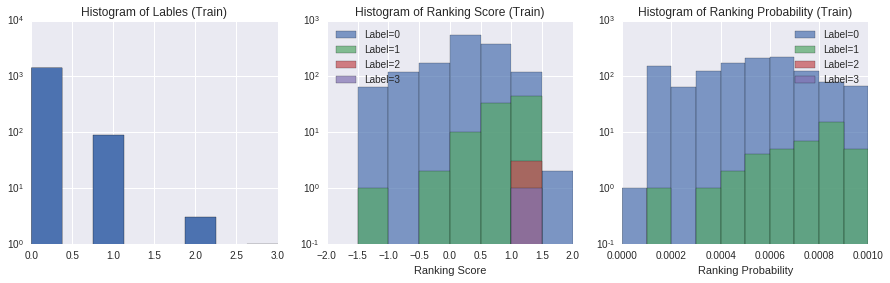

In [43]:
plt.figure(figsize=[15, 4])
ax1 = plt.subplot(1, 3, 1); plt.title('Histogram of Lables (Train)')
train_df_['label'].hist(ax=ax1, bins=2*len(labels))
ax1.set_yscale('log')

ax2 = plt.subplot(1, 3, 2); plt.title('Histogram of Ranking Score (Train)')
#hist1, bins1 = np.histogram(rank_train_['rank'], bins=5)
bins1_train = np.r_[np.arange(rmin1_, rmax1_, 0.5), rmax1_]  # [-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0]
for l in labels:
    ix = train_df_[train_df_['label'] == l].index
    rank_train_.loc[ix, 'rank'].hist(ax=ax2, bins=bins1_train, label='Label=%d' % l, alpha=0.7)
ax2.set_yscale('log')
ax2.set_ylim(ymin=0.1)
ax2.set_xlabel('Ranking Score')
plt.legend(loc='upper left')

ax3 = plt.subplot(1, 3, 3); plt.title('Histogram of Ranking Probability (Train)')
#hist2, bins2 = np.histogram(rank_train_['probability'], bins=5)
bins2_train = np.r_[np.arange(pmin1_, pmax1_, 0.0001), pmax1_]  # [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
for l in labels:
    ix = train_df_[train_df_['label'] == l].index
    rank_train_.loc[ix, 'probability'].hist(ax=ax3, bins=bins2_train, label='Label=%d' % l, alpha=0.7)
ax3.set_yscale('log')
ax3.set_ylim(ymin=0.1)
ax3.set_xlabel('Ranking Probability')
plt.legend(loc='upper right')
print('NOTE: labels of POI in training set is query specific')

<a id='sec2.5'></a>

## 2.5 Recommendation based on POI Ranking

Recommend trajectories based on ranking of POIs.

In [44]:
if run_rank == True:
    recdict_rank = dict()
    cost = 1000
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory too short
        if len(t) < 3: continue
            
        # TSP, generally an ILP very hard for solvers (GUROBI/CBC)
        if t[0] == t[-1]: continue

        if uspecific == True:
            user = traj_user.loc[tid, 'userID']
            trajid_set_user = traj_user[traj_user['userID'] == user].index.tolist()
            trajid_set_other = traj_user[traj_user['userID'] != user].index.tolist()
            assert(tid in trajid_set_user)
            trajid_set_add = [x for x in trajid_set_user if x != tid]
            trajid_list_train = trajid_set_other.copy()
            assert(KX > 0)
            for k in range(KX):
                trajid_list_train = trajid_list_train + trajid_set_add
        else:
            trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        trajid_list_train.append(tid)  # make sure the start/end is in training set
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        # trajectory too long
        if len(t) > poi_info.shape[0]: continue
            
        # start/end is not in training set
        #if not (t[0] in poi_info.index and t[-1] in poi_info.index): continue
        
        print(t, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()

        # POI popularity based ranking
        poi_info.sort_values(by='popularity', ascending=False, inplace=True)
        ranks1 = poi_info.index.tolist()
        rec_pop = [t[0]] + [x for x in ranks1 if x not in {t[0], t[-1]}][:len(t)-2] + [t[-1]]

        # POI feature based ranking
        train_df = gen_train_df(trajid_list_train, df_columns, traj_all, poi_info, query_id_dict)
        ranksvm = RankSVM(ranksvm_dir, useLinear=True)
        ranksvm.train(train_df, cost=cost)
        test_df = gen_test_df(t[0], t[-1], len(t), df_columns, poi_info, query_id_dict)
        rank_df = ranksvm.predict(test_df)
        rank_df.sort_values(by='rank', ascending=False, inplace=True)
        ranks2 = rank_df['poiID'].tolist()
        rec_feature = [t[0]] + [x for x in ranks2 if x not in {t[0], t[-1]}][:len(t)-2] + [t[-1]]

        recdict_rank[tid] = {'REAL':t, 'REC_POP':rec_pop, 'REC_FEATURE':rec_feature}

        print(' '*10, rec_pop)
        print(' '*10, rec_feature); sys.stdout.flush()

[13, 21, 2] #1 ->
           [13, 16, 2]
           [13, 16, 2]
[2, 21, 16] #2 ->
           [2, 21, 16]
           [2, 21, 16]
[28, 2, 13] #3 ->
           [28, 2, 13]
           [28, 2, 13]
[2, 16, 1, 12, 21, 14] #4 ->
           [2, 16, 21, 1, 26, 14]
           [2, 21, 16, 12, 20, 14]
[9, 10, 15] #5 ->
           [9, 2, 15]
           [9, 26, 15]
[19, 11, 28] #6 ->
           [19, 2, 28]
           [19, 2, 28]
[12, 1, 16, 21, 2] #7 ->
           [12, 16, 21, 1, 2]
           [12, 21, 16, 20, 2]
[28, 11, 16] #8 ->
           [28, 2, 16]
           [28, 2, 16]
[1, 2, 21] #9 ->
           [1, 2, 21]
           [1, 2, 21]
[13, 2, 21, 16] #10 ->
           [13, 2, 21, 16]
           [13, 2, 21, 16]
[9, 26, 2] #11 ->
           [9, 16, 2]
           [9, 26, 2]
[1, 16, 2] #12 ->
           [1, 16, 2]
           [1, 21, 2]
[16, 21, 26] #13 ->
           [16, 2, 26]
           [16, 2, 26]
[17, 26, 27] #14 ->
           [17, 2, 27]
           [17, 16, 27]
[15, 25, 26] #15 ->
           [15, 

In [45]:
if run_rank == True:
    pickle.dump(recdict_rank, open(frecdict_rank, 'bw'))

In [46]:
if run_rank == True:
    F11_rank = []
    F12_rank = []
    for key in sorted(recdict_rank.keys()):
        F11_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        F12_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    print('POP    : %.3f, %.3f' % (np.mean(F11_rank), np.std(F11_rank)))
    print('FEATURE: %.3f, %.3f' % (np.mean(F12_rank), np.std(F12_rank)))

POP    : 0.750, 0.153
FEATURE: 0.793, 0.161


<a id='sec3'></a>

# 3. Factorise Transition Probabilities in POI Feature Space

Estimate a transition matrix for each feature of POI, transition probabilities (matrix) between different POI features (vector) is obtrained by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the individual transition matrix corresponding to each feature.

<a id='sec3.1'></a>

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.2$ times the minimum value of that row) if there exists a zero cell.

In [47]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()    
        if len(nonzeroidx) < transmat.columns.shape[0]:
            if len(nonzeroidx) == 0:  # all zeros in row
                transmat.iloc[row] = 1 / transmat.columns.shape[0]  # uniform distribution
            else:
                minv = np.min(transmat.iloc[row, nonzeroidx])
                EPS = 0.2 * minv  # row-specific smooth factor
                #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
                #transmat.iloc[row, zeroidx] = EPS
                transmat.iloc[row] += EPS
                rowsum = np.sum(transmat.iloc[row])
                assert(rowsum > 0)
                transmat.iloc[row] /= rowsum
        else:
            assert(len(nonzeroidx) == transmat.columns.shape[0])  # all non-zero in row
            transmat.iloc[row] /= np.sum(transmat.iloc[row])
    return transmat

POIs in training set.

In [48]:
poi_train_ = traj_all[traj_all['trajID'].isin(trajid_set_all)]['poiID'].unique().tolist()
poi_train_.sort()
#poi_train

<a id='sec3.2'></a>

## 3.2 Transition Matrix between POI Cateogries

In [49]:
poi_cats = poi_all.loc[poi_train_, 'poiCat'].unique().tolist()
poi_cats.sort()
poi_cats

['Education',
 'Museum',
 'Park',
 'Religion',
 'Shopping',
 'Structure',
 'Transport']

In [50]:
transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                            columns=poi_cats, index=poi_cats)

Count the number of transitions between POI categories.

In [51]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            cat1 = poi_all.loc[p1, 'poiCat']
            cat2 = poi_all.loc[p2, 'poiCat']
            transmat_cat.loc[cat1, cat2] += 1

In [52]:
transmat_cat

,Education,Museum,Park,Religion,Shopping,Structure,Transport
Education,11,6,0,0,7,7,5
Museum,8,6,0,3,7,3,11
Park,0,0,0,0,0,0,0
Religion,0,1,1,1,0,4,4
Shopping,4,9,0,2,0,4,10
Structure,8,3,0,0,1,3,6
Transport,3,14,0,2,12,4,4


Normalise each row to obtain transition probabilities.

In [53]:
transmat_cat = normalise_transmat(transmat_cat)

In [54]:
transmat_cat

,Education,Museum,Park,Religion,Shopping,Structure,Transport
Education,0.279070,0.162791,0.023256,0.023256,0.186047,0.186047,0.139535
Museum,0.203791,0.156398,0.014218,0.085308,0.180095,0.085308,0.274882
Park,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
Religion,0.016129,0.096774,0.096774,0.096774,0.016129,0.338710,0.338710
Shopping,0.138365,0.295597,0.012579,0.075472,0.012579,0.138365,0.327044
Structure,0.366071,0.142857,0.008929,0.008929,0.053571,0.142857,0.276786
Transport,0.081340,0.344498,0.009569,0.057416,0.296651,0.105263,0.105263


Combine the above steps.

In [55]:
def gen_transmat_cat(trajid_list, traj_all, poi_info, poi_cats=poi_cats):    
    transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = extract_traj(tid, traj_all)
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat)

<a id='sec3.3'></a>

## 3.3 Transition Matrix between POI Popularity Classes

In [56]:
poi_pops = poi_info_.loc[poi_train_, 'popularity']
sorted(poi_pops.unique().tolist())

[1, 2, 4, 5, 8, 9, 12, 13, 14, 17, 20, 26, 29, 36]

Discretize POI popularity with uniform log-scale bins (#bins $\le 5$).

In [57]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 1.55630250077


In [58]:
nbins_pop = 2
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if uspecific == True:
    logbins_pop[-1] = KX * logbins_pop[-1]  # deal with overflow
logbins_pop

array([     0.,     10.,  10000.])

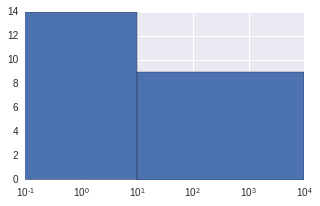

In [59]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [60]:
transmat_pop = pd.DataFrame(data=np.zeros((nbins_pop, nbins_pop), dtype=np.float), \
                            columns=np.arange(1, nbins_pop+1), index=np.arange(1, nbins_pop+1))

Count the number of transitions between POI popularity classes.

In [61]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            pop1 = poi_info_.loc[p1, 'popularity']
            pop2 = poi_info_.loc[p2, 'popularity']
            pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
            transmat_pop.loc[pc1, pc2] += 1

In [62]:
transmat_pop

,1,2
1,7,34
2,35,98


Normalise each row to obtain transition probabilities.

In [63]:
transmat_pop = normalise_transmat(transmat_pop)

In [64]:
transmat_pop

,1,2
1,0.170732,0.829268
2,0.263158,0.736842


Combine the above steps.

In [65]:
def gen_transmat_pop(trajid_list, traj_all, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = extract_traj(tid, traj_all)
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop), logbins_pop

<a id='sec3.4'></a>

## 3.4 Transition Matrix between the Number of POI Visit Classes

In [66]:
poi_visits = poi_info_.loc[poi_train_, 'nVisit']
#sorted(poi_visits.unique().tolist())

Discretize the number of POI visit with uniform log-scale bins (#bins $\le 5$).

In [67]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 1.56820172407


In [68]:
nbins_visit = 2
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if uspecific == True:
    logbins_visit[-1] = KX * logbins_visit[-1]  # deal with overflow
logbins_visit

array([     0.,     10.,  10000.])

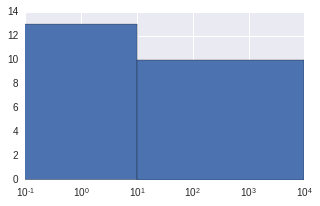

In [69]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [70]:
transmat_visit = pd.DataFrame(data=np.zeros((nbins_visit, nbins_visit), dtype=np.float), \
                              columns=np.arange(1, nbins_visit+1), index=np.arange(1, nbins_visit+1))

Count the number of transitions between POI popularity classes.

In [71]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            visit1 = poi_info_.loc[p1, 'nVisit']
            visit2 = poi_info_.loc[p2, 'nVisit']
            vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
            transmat_visit.loc[vc1, vc2] += 1

In [72]:
transmat_visit

,1,2
1,6,29
2,26,113


Normalise each row to obtain transition probabilities.

In [73]:
transmat_visit = normalise_transmat(transmat_visit)

In [74]:
transmat_visit

,1,2
1,0.171429,0.828571
2,0.187050,0.812950


Combine the above steps.

In [75]:
def gen_transmat_visit(trajid_list, traj_all, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                  columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = extract_traj(tid, traj_all)
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit), logbins_visit

<a id='sec3.5'></a>

## 3.5 Transition Matrix between POI Average Visit Duration Classes

In [76]:
poi_durations = poi_info_.loc[poi_train_, 'avgDuration']
#sorted(poi_durations.unique().tolist())

Discretize POI average visit duration with uniform log-scale bins (#bins $\le 5$).

In [77]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.51541017229


In [78]:
nbins_duration = 3
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
if uspecific == True:
    logbins_duration[-1] = KX * logbins_duration[-1]  # deal with overflow
logbins_duration

array([  0.00000000e+00,   2.15443469e+01,   4.64158883e+02,
         1.00000000e+06])

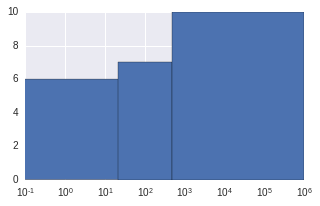

In [79]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [80]:
transmat_duration = pd.DataFrame(data=np.zeros((nbins_duration, nbins_duration), dtype=np.float), \
                                 columns=np.arange(1, nbins_duration+1), index=np.arange(1, nbins_duration+1))

Count the number of transitions between POI average visit duration classes.

In [81]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            d1 = poi_info_.loc[p1, 'avgDuration']
            d2 = poi_info_.loc[p2, 'avgDuration']
            dc1, dc2 = np.digitize([d1, d2], logbins_duration)
            transmat_duration.loc[dc1, dc2] += 1

In [82]:
transmat_duration

,1,2,3
1,1,5,9
2,5,25,41
3,10,46,32


Normalise each row to obtain transition probabilities.

In [83]:
transmat_duration = normalise_transmat(transmat_duration)

In [84]:
transmat_duration

,1,2,3
1,0.066667,0.333333,0.600000
2,0.070423,0.352113,0.577465
3,0.113636,0.522727,0.363636


Combine the above steps.

In [85]:
def gen_transmat_duration(trajid_list, traj_all, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                     columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = extract_traj(tid, traj_all)
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration), logbins_duration

<a id='sec3.6'></a>

## 3.6 Transition Matrix between POI Neighborhood Classes

Compute POI neighborhoods, i.e., clustering POI (lat, lon) in training set using k-means, #clusters $\le 5$.

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [86]:
#from sklearn.cluster import KMeans
X = poi_all.loc[poi_train_, ['poiLon', 'poiLat']]
nclusters = 4

In [87]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [88]:
clusters = kmeans.predict(X)
clusters

array([1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 2, 1, 1], dtype=int32)

In [89]:
poi_clusters = pd.DataFrame(data=clusters, index=poi_train_)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

In [90]:
diff = poi_all.loc[poi_train_, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train_, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
ratio

2.0774414137206629

Scatter plot of POI coordinates with clustering results.

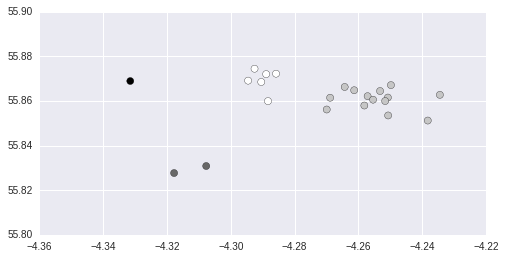

In [91]:
height = 4; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train_, 'poiLon'], poi_all.loc[poi_train_, 'poiLat'], c=clusters, s=50)

In [92]:
transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                 columns=np.arange(nclusters), index=np.arange(nclusters))

Count the number of transitions between POIs in different clusters.

In [93]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) > 1:
        for pi in range(len(t)-1):
            p1 = t[pi]
            p2 = t[pi+1]
            c1 = poi_clusters.loc[p1, 'clusterID']
            c2 = poi_clusters.loc[p2, 'clusterID']
            transmat_neighbor.loc[c1, c2] += 1

In [94]:
transmat_neighbor

,0,1,2,3
0,32,14,1,0
1,7,115,0,1
2,2,0,1,0
3,0,1,0,0


Normalise each row to obtain transition probabilities.

In [95]:
transmat_neighbor = normalise_transmat(transmat_neighbor)

In [96]:
transmat_neighbor

,0,1,2,3
0,0.673640,0.297071,0.025105,0.004184
1,0.058158,0.930533,0.001616,0.009693
2,0.578947,0.052632,0.315789,0.052632
3,0.111111,0.666667,0.111111,0.111111


Combine the above steps.

In [97]:
def gen_transmat_neighbor(trajid_list, traj_all, poi_info, poi_clusters=poi_clusters):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                     columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = extract_traj(tid, traj_all)
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor), poi_clusters

<a id='sec3.7'></a>

## 3.7 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

In [98]:
#from scipy.linalg import kron
transmat_value = transmat_cat.values
for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
    transmat_value = kron(transmat_value, transmat.values)

Index of Kronecker product.

In [99]:
transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                     transmat_duration.index, transmat_neighbor.index))

In [100]:
transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
transmat_feature.index.name = '(poiTheme, popularity, avgDuration, clusterID)'
#transmat_feature.head()

In [101]:
print(transmat_cat.shape)
print(transmat_pop.shape)
print(transmat_visit.shape)
print(transmat_duration.shape)
print(transmat_neighbor.shape)
print(transmat_feature.shape)

(7, 7)
(2, 2)
(2, 2)
(3, 3)
(4, 4)
(336, 336)


In [102]:
transmat_feature.head()

,"(Education, 1, 1, 1, 0)","(Education, 1, 1, 1, 1)","(Education, 1, 1, 1, 2)","(Education, 1, 1, 1, 3)","(Education, 1, 1, 2, 0)","(Education, 1, 1, 2, 1)","(Education, 1, 1, 2, 2)","(Education, 1, 1, 2, 3)","(Education, 1, 1, 3, 0)","(Education, 1, 1, 3, 1)",...,"(Transport, 2, 2, 1, 2)","(Transport, 2, 2, 1, 3)","(Transport, 2, 2, 2, 0)","(Transport, 2, 2, 2, 1)","(Transport, 2, 2, 2, 2)","(Transport, 2, 2, 2, 3)","(Transport, 2, 2, 3, 0)","(Transport, 2, 2, 3, 1)","(Transport, 2, 2, 3, 2)","(Transport, 2, 2, 3, 3)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(Education, 1, 1, 1, 0)",0.000367,0.000162,1.367012e-05,0.000002,0.001834,0.000809,0.000068,0.000011,0.003301,0.001456,...,0.000160,0.000027,0.021529,0.009494,0.000802,0.000134,0.038751,0.017089,0.001444,0.000241
"(Education, 1, 1, 1, 1)",0.000032,0.000507,8.796872e-07,0.000005,0.000158,0.002533,0.000004,0.000026,0.000285,0.004560,...,0.000010,0.000062,0.001859,0.029738,0.000052,0.000310,0.003346,0.053529,0.000093,0.000558
"(Education, 1, 1, 1, 2)",0.000315,0.000029,1.719557e-04,0.000029,0.001576,0.000143,0.000860,0.000143,0.002837,0.000258,...,0.002018,0.000336,0.018502,0.001682,0.010092,0.001682,0.033304,0.003028,0.018166,0.003028
"(Education, 1, 1, 1, 3)",0.000061,0.000363,6.050293e-05,0.000061,0.000303,0.001815,0.000303,0.000303,0.000545,0.003267,...,0.000710,0.000710,0.003551,0.021306,0.003551,0.003551,0.006392,0.038350,0.006392,0.006392
"(Education, 1, 1, 2, 0)",0.000387,0.000171,1.444027e-05,0.000002,0.001937,0.000854,0.000072,0.000012,0.003177,0.001401,...,0.000170,0.000028,0.022741,0.010029,0.000848,0.000141,0.037296,0.016447,0.001390,0.000232


The result of [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) should be normalised to obtain transition probabilities.

In [103]:
#from scipy.misc import logsumexp
logtransmat_feature = np.log(transmat_feature)
for row in range(logtransmat_feature.shape[0]):
    logtransmat_feature.iloc[row] -= logsumexp(logtransmat_feature.iloc[row])
logtransmat_feature.head()

,"(Education, 1, 1, 1, 0)","(Education, 1, 1, 1, 1)","(Education, 1, 1, 1, 2)","(Education, 1, 1, 1, 3)","(Education, 1, 1, 2, 0)","(Education, 1, 1, 2, 1)","(Education, 1, 1, 2, 2)","(Education, 1, 1, 2, 3)","(Education, 1, 1, 3, 0)","(Education, 1, 1, 3, 1)",...,"(Transport, 2, 2, 1, 2)","(Transport, 2, 2, 1, 3)","(Transport, 2, 2, 2, 0)","(Transport, 2, 2, 2, 1)","(Transport, 2, 2, 2, 2)","(Transport, 2, 2, 2, 3)","(Transport, 2, 2, 3, 0)","(Transport, 2, 2, 3, 1)","(Transport, 2, 2, 3, 2)","(Transport, 2, 2, 3, 3)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(Education, 1, 1, 1, 0)",-7.910653,-8.729378,-11.200298,-12.992058,-6.301215,-7.119940,-9.590860,-11.382620,-5.713429,-6.532153,...,-8.737459,-10.529218,-3.838376,-4.657100,-7.128021,-8.919780,-3.250589,-4.069314,-6.540234,-8.331994
"(Education, 1, 1, 1, 1)",-10.360181,-7.587592,-13.943699,-12.151940,-8.750743,-5.978154,-12.334262,-10.542502,-8.162956,-5.390367,...,-11.480860,-9.689100,-6.287903,-3.515314,-9.871422,-8.079663,-5.700116,-2.927528,-9.283635,-7.491876
"(Education, 1, 1, 1, 2)",-8.062138,-10.460033,-8.668274,-10.460033,-6.452700,-8.850595,-7.058836,-8.850595,-5.864913,-8.262809,...,-6.205434,-7.997194,-3.989860,-6.387756,-4.595996,-6.387756,-3.402074,-5.799969,-4.008210,-5.799969
"(Education, 1, 1, 1, 3)",-9.712819,-7.921059,-9.712819,-9.712819,-8.103381,-6.311621,-8.103381,-8.103381,-7.515594,-5.723835,...,-7.249979,-7.249979,-5.640541,-3.848782,-5.640541,-5.640541,-5.052755,-3.260995,-5.052755,-5.052755
"(Education, 1, 1, 2, 0)",-7.855845,-8.674570,-11.145490,-12.937249,-6.246407,-7.065132,-9.536052,-11.327812,-5.751711,-6.570435,...,-8.682650,-10.474410,-3.783568,-4.602292,-7.073213,-8.864972,-3.288871,-4.107596,-6.578516,-8.370276


In [104]:
logtransmat_feature.max().sort_values(ascending=False).head(10)

(Education, 2, 2, 3, 1)   -1.963014
(Museum, 2, 2, 3, 1)      -2.023755
(Structure, 2, 2, 3, 1)   -2.040699
(Transport, 2, 2, 3, 1)   -2.040699
(Education, 2, 2, 2, 1)   -2.100884
(Museum, 2, 2, 2, 1)      -2.161625
(Shopping, 2, 2, 3, 1)    -2.173287
(Structure, 2, 2, 2, 1)   -2.178569
(Transport, 2, 2, 2, 1)   -2.178569
(Education, 2, 2, 3, 0)   -2.286075
dtype: float64

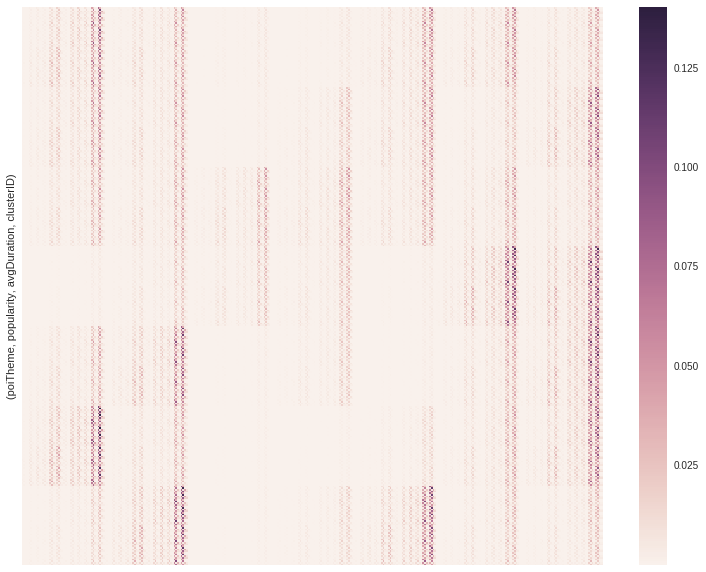

In [105]:
plt.figure(figsize=[13, 10])
sns.heatmap(np.exp(logtransmat_feature), xticklabels=False, yticklabels=False)

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [106]:
feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
poi_features = pd.DataFrame(data=np.zeros((len(poi_train_), len(feature_names))), \
                            columns=feature_names, index=poi_train_)
poi_features.index.name = 'poiID'

In [107]:
poi_features['poiCat'] = poi_info_.loc[poi_train_, 'poiCat']
poi_features['popularity'] = np.digitize(poi_info_.loc[poi_train_, 'popularity'], logbins_pop)
poi_features['nVisit'] = np.digitize(poi_info_.loc[poi_train_, 'nVisit'], logbins_visit)
poi_features['avgDuration'] = np.digitize(poi_info_.loc[poi_train_, 'avgDuration'], logbins_duration)
poi_features['clusterID'] = poi_clusters.loc[poi_train_, 'clusterID']

In [108]:
ix = transmat_feature.index[0]; ix1 = transmat_feature.index[1]
# simply use df.loc[tuple,:] will trigger an error as pandas treat the tuple as multiindex
# see https://github.com/pydata/pandas/issues/7548
#transmat_feature.loc[(ix,),]   # OK
#transmat_feature.loc[(ix,),:]  # OK
transmat_feature.loc[(ix,), (ix1,)] 

,"(Education, 1, 1, 1, 1)"
"(poiTheme, popularity, avgDuration, clusterID)",
"(Education, 1, 1, 1, 0)",0.000162


In [109]:
poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train_), len(poi_train_)), dtype=np.float), \
                               columns=poi_train_, index=poi_train_)

Copy transition values between features with corresponding POIs.

In [110]:
for p1 in poi_logtransmat.index:
    rix = tuple(poi_features.loc[p1])
    for p2 in poi_logtransmat.columns:
        cix = tuple(poi_features.loc[p2])
        value_ = transmat_feature.loc[(rix,), (cix,)]
        #print(value_.values)
        poi_logtransmat.loc[p1, p2] = value_.values[0, 0]

In [111]:
poi_logtransmat.head(11)

,1,2,5,6,8,9,10,11,12,13,...,17,19,20,21,22,25,26,27,28,29
1,0.021336,0.021336,0.000006,0.000548,0.001355,0.000122,0.001030,0.001355,0.008464,0.011638,...,3.113063e-06,0.000034,0.030671,0.100376,0.000159,0.000516,0.004364,0.000003,0.006668,0.000548
2,0.021336,0.021336,0.000006,0.000548,0.001355,0.000122,0.001030,0.001355,0.008464,0.011638,...,3.113063e-06,0.000034,0.030671,0.100376,0.000159,0.000516,0.004364,0.000003,0.006668,0.000548
5,0.028931,0.028931,0.000023,0.000137,0.000952,0.000088,0.003726,0.000952,0.002557,0.015780,...,7.468783e-05,0.000023,0.016073,0.052602,0.000112,0.000373,0.015780,0.000205,0.003215,0.000137
6,0.040382,0.040382,0.000002,0.000191,0.001329,0.000046,0.001950,0.001329,0.003569,0.022026,...,1.085930e-06,0.000012,0.022434,0.073421,0.000156,0.000195,0.008260,0.000003,0.004487,0.000191
8,0.032442,0.032442,0.000004,0.000432,0.002764,0.000248,0.004055,0.002764,0.019203,0.005407,...,8.746890e-07,0.000036,0.062180,0.054408,0.000230,0.000145,0.002366,0.000003,0.013517,0.000576
9,0.016447,0.016447,0.000001,0.000085,0.001401,0.001937,0.074592,0.001401,0.004130,0.002741,...,8.423488e-06,0.000258,0.013372,0.011700,0.000117,0.001130,0.043512,0.000079,0.002674,0.000114
10,0.009029,0.009029,0.000003,0.000232,0.001484,0.004837,0.040949,0.001484,0.009271,0.001505,...,2.285995e-05,0.000701,0.017306,0.015143,0.000124,0.002822,0.023887,0.000084,0.003762,0.000309
11,0.032442,0.032442,0.000004,0.000432,0.002764,0.000248,0.004055,0.002764,0.019203,0.005407,...,8.746890e-07,0.000036,0.062180,0.054408,0.000230,0.000145,0.002366,0.000003,0.013517,0.000576
12,0.050547,0.050547,0.000003,0.000292,0.004789,0.000183,0.006318,0.004789,0.012691,0.008425,...,5.914572e-07,0.000024,0.041095,0.035959,0.000399,0.000106,0.003686,0.000006,0.008219,0.000389
13,0.068654,0.068654,0.000018,0.001763,0.000269,0.000024,0.000204,0.000269,0.001678,0.019615,...,8.745028e-07,0.000110,0.098690,0.028197,0.001612,0.000145,0.001226,0.000010,0.021454,0.001763


Deal with POI features that correspond to more than once POIs.

In [112]:
features_dup = dict()
for poi in poi_features.index:
    key = tuple(poi_features.loc[poi])
    if key in features_dup:
        features_dup[key].append(poi)
    else:
        features_dup[key] = [poi]
features_dup

{('Education', 1, 1, 2, 0): [9],
 ('Education', 1, 1, 3, 1): [8, 11],
 ('Education', 1, 2, 2, 1): [12],
 ('Education', 2, 2, 3, 0): [10],
 ('Museum', 1, 1, 1, 2): [17],
 ('Museum', 1, 1, 2, 0): [25],
 ('Museum', 2, 2, 2, 1): [21],
 ('Museum', 2, 2, 3, 0): [26],
 ('Park', 1, 1, 3, 1): [22],
 ('Religion', 1, 1, 2, 1): [14],
 ('Religion', 2, 2, 3, 1): [13],
 ('Shopping', 1, 1, 3, 0): [15],
 ('Shopping', 2, 2, 2, 1): [16],
 ('Structure', 1, 1, 1, 0): [19],
 ('Structure', 1, 1, 1, 1): [29],
 ('Structure', 1, 1, 3, 2): [27],
 ('Structure', 2, 2, 1, 1): [28],
 ('Structure', 2, 2, 2, 1): [20],
 ('Transport', 1, 1, 1, 1): [6],
 ('Transport', 1, 1, 1, 3): [5],
 ('Transport', 2, 2, 3, 1): [1, 2]}

In [113]:
for feature in sorted(features_dup.keys()):
    n = len(features_dup[feature])
    if n > 1:
        group = features_dup[feature]
        v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
        
        # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
        for poi in group:
            poi_logtransmat[poi] /= n
        
        # outgoing transition value has already been duplicated (value copied above)
        
        # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
        # from a POI to all other POIs in the same group (excluding POI self-loop)
        v2 = v1 / (n - 1)
        for pair in itertools.permutations(group, 2):
            poi_logtransmat.loc[pair[0], pair[1]] = v2

Make the transition value of all self-loops of POIs to $0$.

In [114]:
for p1 in poi_logtransmat.index:
    poi_logtransmat.loc[p1, p1] = 0

In [115]:
poi_logtransmat.head(11)

,1,2,5,6,8,9,10,11,12,13,...,17,19,20,21,22,25,26,27,28,29
1,0.000000,0.021336,0.000006,0.000548,0.000677,0.000122,0.001030,0.000677,0.008464,0.011638,...,3.113063e-06,0.000034,0.030671,0.100376,0.000159,0.000516,0.004364,0.000003,0.006668,0.000548
2,0.021336,0.000000,0.000006,0.000548,0.000677,0.000122,0.001030,0.000677,0.008464,0.011638,...,3.113063e-06,0.000034,0.030671,0.100376,0.000159,0.000516,0.004364,0.000003,0.006668,0.000548
5,0.014465,0.014465,0.000000,0.000137,0.000476,0.000088,0.003726,0.000476,0.002557,0.015780,...,7.468783e-05,0.000023,0.016073,0.052602,0.000112,0.000373,0.015780,0.000205,0.003215,0.000137
6,0.020191,0.020191,0.000002,0.000000,0.000665,0.000046,0.001950,0.000665,0.003569,0.022026,...,1.085930e-06,0.000012,0.022434,0.073421,0.000156,0.000195,0.008260,0.000003,0.004487,0.000191
8,0.016221,0.016221,0.000004,0.000432,0.000000,0.000248,0.004055,0.002764,0.019203,0.005407,...,8.746890e-07,0.000036,0.062180,0.054408,0.000230,0.000145,0.002366,0.000003,0.013517,0.000576
9,0.008224,0.008224,0.000001,0.000085,0.000701,0.000000,0.074592,0.000701,0.004130,0.002741,...,8.423488e-06,0.000258,0.013372,0.011700,0.000117,0.001130,0.043512,0.000079,0.002674,0.000114
10,0.004515,0.004515,0.000003,0.000232,0.000742,0.004837,0.000000,0.000742,0.009271,0.001505,...,2.285995e-05,0.000701,0.017306,0.015143,0.000124,0.002822,0.023887,0.000084,0.003762,0.000309
11,0.016221,0.016221,0.000004,0.000432,0.002764,0.000248,0.004055,0.000000,0.019203,0.005407,...,8.746890e-07,0.000036,0.062180,0.054408,0.000230,0.000145,0.002366,0.000003,0.013517,0.000576
12,0.025274,0.025274,0.000003,0.000292,0.002394,0.000183,0.006318,0.002394,0.000000,0.008425,...,5.914572e-07,0.000024,0.041095,0.035959,0.000399,0.000106,0.003686,0.000006,0.008219,0.000389
13,0.034327,0.034327,0.000018,0.001763,0.000134,0.000024,0.000204,0.000134,0.001678,0.000000,...,8.745028e-07,0.000110,0.098690,0.028197,0.001612,0.000145,0.001226,0.000010,0.021454,0.001763


Normalise and compute log probability.

In [116]:
for p1 in poi_logtransmat.index:
    rowsum = poi_logtransmat.loc[p1].sum()
    assert(rowsum > 0)
    logrowsum = np.log10(rowsum)
    for p2 in poi_logtransmat.columns:
        if p1 == p2:
            poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
        else:
            poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum

In [117]:
poi_logtransmat.head(11)

,1,2,5,6,8,9,10,11,12,13,...,17,19,20,21,22,25,26,27,28,29
1,-inf,-1.111731,-4.684416,-2.702144,-2.609998,-3.355480,-2.427825,-2.609998,-1.513255,-1.374973,...,-4.947657,-3.906264,-0.954123,-0.439214,-3.238387,-2.728597,-1.800941,-4.957417,-1.616881,-2.702144
2,-1.111731,-inf,-4.684416,-2.702144,-2.609998,-3.355480,-2.427825,-2.609998,-1.513255,-1.374973,...,-4.947657,-3.906264,-0.954123,-0.439214,-3.238387,-2.728597,-1.800941,-4.957417,-1.616881,-2.702144
5,-1.111543,-1.111543,-inf,-3.135384,-2.594145,-3.326539,-1.700638,-2.594145,-1.864141,-1.073755,...,-3.398625,-3.913535,-1.065786,-0.550876,-3.222534,-2.699655,-1.073755,-2.959292,-1.764756,-3.135384
6,-1.079582,-1.079582,-5.085694,-inf,-2.562184,-3.720546,-2.094646,-2.562184,-1.832180,-1.041794,...,-5.348935,-4.307543,-1.033825,-0.518915,-3.190573,-3.093663,-1.467763,-4.909603,-1.732795,-3.103423
8,-1.205971,-1.205971,-4.762990,-2.780719,-inf,-3.021051,-1.808031,-1.974539,-1.132684,-1.683093,...,-5.474195,-3.859900,-0.622395,-0.680387,-3.053720,-3.255134,-2.042115,-4.911053,-1.285153,-2.655780
9,-1.358918,-1.358918,-5.193588,-3.342329,-2.428515,-inf,-0.401290,-2.428515,-1.658082,-1.836039,...,-4.348490,-2.861823,-1.147793,-1.205785,-3.206667,-2.220845,-0.635373,-3.376684,-1.846763,-3.217390
10,-1.387753,-1.387753,-4.528394,-2.677136,-2.171986,-1.357781,-inf,-2.171986,-1.075243,-1.864874,...,-3.683296,-2.196630,-0.804176,-0.862168,-2.950137,-1.591864,-0.664209,-3.120154,-1.466934,-2.552197
11,-1.205971,-1.205971,-4.762990,-2.780719,-1.974539,-3.021051,-1.808031,-inf,-1.132684,-1.683093,...,-5.474195,-3.859900,-0.622395,-0.680387,-3.053720,-3.255134,-2.042115,-4.911053,-1.285153,-2.655780
12,-0.902638,-0.902638,-4.822179,-2.839908,-1.926094,-3.044028,-1.504698,-1.926094,-inf,-1.379760,...,-5.533384,-3.919089,-0.691513,-0.749505,-2.704246,-3.278111,-1.738781,-4.561578,-1.390483,-2.714969
13,-0.831445,-0.831445,-4.103099,-2.120828,-3.238927,-3.984410,-3.056754,-3.238927,-2.142185,-inf,...,-5.425319,-3.324948,-0.372807,-0.916875,-2.159746,-3.206258,-2.278603,-4.376101,-1.035565,-2.120828


Plot transition matrix heatmap.

In [118]:
prob_mat = np.power(10, poi_logtransmat)

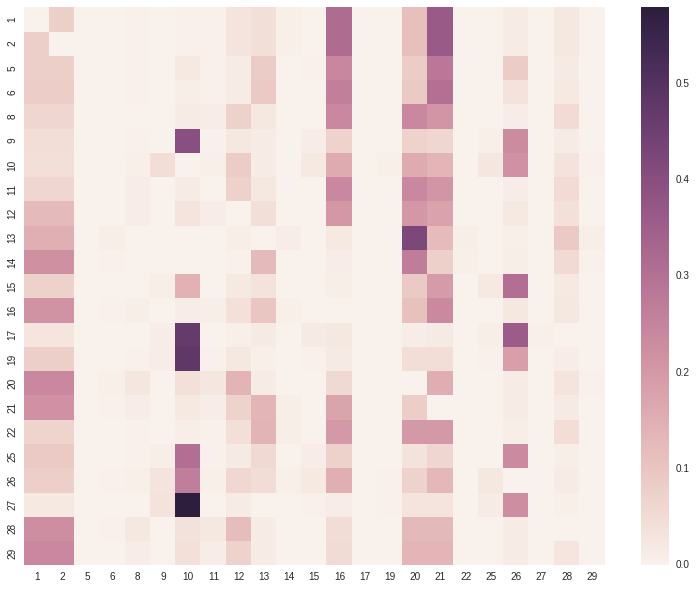

In [119]:
plt.figure(figsize=[13, 10])
#plt.imshow(prob_mat, interpolation='none', cmap=plt.cm.hot)  # OK
#ticks = prob_mat.index
#plt.xticks(np.arange(prob_mat.shape[0]), ticks)
#plt.yticks(np.arange(prob_mat.shape[0]), ticks)
#plt.xlabel('POI ID')
#plt.ylabel('POI ID')
sns.heatmap(prob_mat)

In [120]:
#print(prob_mat.loc[2, 1])
#print(poi_all.loc[[2, 17]])
#d_ = calc_dist(poi_all.loc[2, 'poiLon'], poi_all.loc[2, 'poiLat'], poi_all.loc[1, 'poiLon'], poi_all.loc[1, 'poiLat'])
#print('Distance between POI %d and %d is %.3f km.' % (2, 1, d_))

Combine the above steps.

In [121]:
def gen_poi_logtransmat(trajid_list, traj_all, poi_info):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_all, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_all, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_all, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_all, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_all, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = poi_info.index.tolist()
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    return poi_logtransmat

<a id='sec3.8'></a>

## 3.8 Recommendation based on POI Transition Matrix

Use dynamic programming to find a possibly non-simple path, i.e., walk.

In [122]:
def find_path(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    # with sub-tours in trajectory, this is not the case any more, but it is nonsense to recommend such trajectories
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:
        if v != ps:
            if withNodeWeight == True:
                A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            else:
                A.loc[2, v] = E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withNodeWeight == True: # ps-~-v1---v
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else:
                values = [A.loc[l-1, v1] + E.loc[v1, v] for v1 in V.index]  # ps-~-v1---v   
            
            minix = np.argmin(values)
            A.loc[l, v] = values[minix]
            B.loc[l, v] = V.index[minix]
            
    path = [pe]
    v = path[-1]
    l = L
    #while v != ps:  #incorrect if 'ps' happens to appear in the middle of a path
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Use integer linear programming (ILP) to find a simple path.

In [123]:
def find_path_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # deal with np.inf which will cause ILP solver failure
    Edges = E.copy()
    INF = 1e6
    for p in Edges.index:
        Edges.loc[p, p] = INF 
    maxL = np.max(Edges.values.flatten())
    if maxL > INF:
        for p in Edges.index:
            Edges.loc[p, p] = maxL    
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMinimize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha*V.loc[int(pj), 'weight'] + beta*Edges.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * Edges.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #gurobi_options = [('TimeLimit', '7200'), ('Threads', '8'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    #pb.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

In [124]:
if run_tran == True:
    recdict_tran = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory too short
        if len(t) < 3: continue
            
        # TSP, generally an ILP very hard for solvers (GUROBI/CBC)
        if t[0] == t[-1]: continue

        if uspecific == True:
            user = traj_user.loc[tid, 'userID']
            trajid_set_user = traj_user[traj_user['userID'] == user].index.tolist()
            trajid_set_other = traj_user[traj_user['userID'] != user].index.tolist()
            assert(tid in trajid_set_user)
            trajid_set_add = [x for x in trajid_set_user if x != tid]
            trajid_list_train = trajid_set_other.copy()
            assert(KX > 0)
            for k in range(KX):
                trajid_list_train = trajid_list_train + trajid_set_add
        else:
            trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
            
        trajid_list_train.append(tid)  # make sure the start/end is in training set
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        # trajectory too long
        if len(t) > poi_info.shape[0]: continue
            
        # start/end is not in training set
        #if not (t[0] in poi_info.index and t[-1] in poi_info.index): continue
        
        print(t, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        poi_logtransmat = gen_poi_logtransmat(trajid_list_train, traj_all, poi_info)
        nodes = poi_info.copy()
        edges = poi_logtransmat.copy()
        edges = -1 * edges  # edge weight is negative log of transition probability

        # DP
        rec_dp = find_path(nodes, edges, t[0], t[-1], len(t))

        # ILP
        rec_ilp = find_path_ILP(nodes, edges, t[0], t[-1], len(t))

        recdict_tran[tid] = {'REAL':t, 'REC_DP':rec_dp, 'REC_ILP':rec_ilp}
        print(' '*10, rec_dp)
        print(' '*10, rec_ilp); sys.stdout.flush()

[13, 21, 2] #1 ->
           [13, 20, 2]
           [13, 20, 2]
[2, 21, 16] #2 ->
           [2, 21, 16]
           [2, 21, 16]
[28, 2, 13] #3 ->
           [28, 21, 13]
           [28, 21, 13]
[2, 16, 1, 12, 21, 14] #4 ->
           [2, 16, 21, 1, 21, 14]
           [2, 16, 1, 21, 13, 14]
[9, 10, 15] #5 ->
           [9, 10, 15]
           [9, 10, 15]
[19, 11, 28] #6 ->
           [19, 10, 28]
           [19, 10, 28]
[12, 1, 16, 21, 2] #7 ->
           [12, 20, 1, 21, 2]
           [12, 20, 1, 21, 2]
[28, 11, 16] #8 ->
           [28, 1, 16]
           [28, 1, 16]
[1, 2, 21] #9 ->
           [1, 16, 21]
           [1, 16, 21]
[13, 2, 21, 16] #10 ->
           [13, 20, 1, 16]
           [13, 20, 1, 16]
[9, 26, 2] #11 ->
           [9, 26, 2]
           [9, 26, 2]
[1, 16, 2] #12 ->
           [1, 21, 2]
           [1, 21, 2]
[16, 21, 26] #13 ->
           [16, 25, 26]
           [16, 25, 26]
[17, 26, 27] #14 ->
           [17, 26, 27]
           [17, 26, 27]
[15, 25, 26] #15 ->
        

In [125]:
if run_tran == True:
    pickle.dump(recdict_tran, open(frecdict_tran, 'bw'))

In [126]:
if run_tran == True:
    F11_tran = []
    F12_tran = []
    for tid in sorted(recdict_tran.keys()):
        F11_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        F12_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
    print('DP : %.3f, %.3f' % (np.mean(F11_tran), np.std(F11_tran)))
    print('ILP: %.3f, %.3f' % (np.mean(F12_tran), np.std(F12_tran)))

DP : 0.742, 0.161
ILP: 0.755, 0.157


<a id='sec4'></a>

# 4. Combine POI Ranking with Factorised Markov Chain

NOTE that:
- Ranking is over POIs (in POI space)
- Transition probabilities of Markov Chain of POI features (in POI feature space)

Two approaches to combine ranking with MC:
- recommend trajectory in POI space: 
  - transform transition matrix of feature vector into transition matrix of POIs,
  - recommend a sequence of POIs.
- recommend trajectory in POI feature space: 
  - transform ranking probability of POIs into ranking probability of POI features,
  - recommend a sequence of features, 
  - transform the squence of features into a sequence of POIs.

Here we implement the first approach, i.e., recommend trajectory in POI space.

Two methods for recommendation:
- find a simple path with maximum objective in a digraph. (by negating log probabilities, it can be reduced to a finding shortest path will $k$-edges, which is probably NP-hard as it is the same as TSP when $L=|P|$, dynamic programming can be used for non-simple path.)
- make greedy choice (of POI or POI feature vector) step-by-step

Here we use dynamic programming to find a possibly non-simple path and use ILP to find a simple path.

In [127]:
if run_comb == True:
    recdict_comb = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory too short
        if len(t) < 3: continue
        
        # TSP, generally an ILP very hard for solvers (GUROBI/CBC)
        if t[0] == t[-1]: continue

        if uspecific == True:
            user = traj_user.loc[tid, 'userID']
            trajid_set_user = traj_user[traj_user['userID'] == user].index.tolist()
            trajid_set_other = traj_user[traj_user['userID'] != user].index.tolist()
            assert(tid in trajid_set_user)
            trajid_set_add = [x for x in trajid_set_user if x != tid]
            trajid_list_train = trajid_set_other.copy()
            assert(KX > 0)
            for k in range(KX):
                trajid_list_train = trajid_list_train + trajid_set_add
        else:
            trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]

        trajid_list_train.append(tid)  # make sure the start/end is in training set
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        # trajectory too long
        if len(t) > poi_info.shape[0]: continue
            
        # start/end is not in training set
        #if not (t[0] in poi_info.index and t[-1] in poi_info.index): continue
        
        print(t, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        train_df = gen_train_df(trajid_list_train, df_columns, traj_all, poi_info, query_id_dict)
        ranksvm = RankSVM(ranksvm_dir, useLinear=True)
        ranksvm.train(train_df)
        test_df = gen_test_df(t[0], t[-1], len(t), df_columns, poi_info, query_id_dict)
        rank_df = ranksvm.predict(test_df)
        rank_df.set_index('poiID', inplace=True)

        nodes = rank_df.copy()
        nodes['weight'] = -np.log(nodes['probability'])  # node weight is negative log of ranking probability
        nodes.drop('probability', axis=1, inplace=True)
        edges = poi_logtransmat.copy()
        edges = -1 * edges  # edge weight is negative log of transition probability

        # DP
        rec_dp = find_path(nodes, edges, t[0], t[-1], len(t), withNodeWeight=True, alpha=ALPHA)

        # ILP
        rec_ilp = find_path_ILP(nodes, edges, t[0], t[-1], len(t), withNodeWeight=True, alpha=ALPHA)

        recdict_comb[tid] = {'REAL':t, 'REC_DP':rec_dp, 'REC_ILP':rec_ilp} # save recommended trajectories
        print(' '*10, rec_dp)
        print(' '*10, rec_ilp); sys.stdout.flush()   

[13, 21, 2] #1 ->
           [13, 20, 2]
           [13, 20, 2]
[2, 21, 16] #2 ->
           [2, 21, 16]
           [2, 21, 16]
[28, 2, 13] #3 ->
           [28, 21, 13]
           [28, 21, 13]
[2, 16, 1, 12, 21, 14] #4 ->
           [2, 21, 2, 21, 2, 14]
           [2, 16, 20, 1, 21, 14]
[9, 10, 15] #5 ->
           [9, 10, 15]
           [9, 10, 15]
[19, 11, 28] #6 ->
           [19, 10, 28]
           [19, 10, 28]
[12, 1, 16, 21, 2] #7 ->
           [12, 16, 2, 21, 2]
           [12, 16, 1, 21, 2]
[28, 11, 16] #8 ->
           [28, 2, 16]
           [28, 2, 16]
[1, 2, 21] #9 ->
           [1, 16, 21]
           [1, 16, 21]
[13, 2, 21, 16] #10 ->
           [13, 20, 2, 16]
           [13, 20, 2, 16]
[9, 26, 2] #11 ->
           [9, 26, 2]
           [9, 26, 2]
[1, 16, 2] #12 ->
           [1, 21, 2]
           [1, 21, 2]
[16, 21, 26] #13 ->
           [16, 2, 26]
           [16, 2, 26]
[17, 26, 27] #14 ->
           [17, 10, 27]
           [17, 10, 27]
[15, 25, 26] #15 ->
           

In [128]:
if run_comb == True:
    pickle.dump(recdict_comb, open(frecdict_comb, 'bw'))

In [129]:
if run_comb == True:
    F11_comb = []
    F12_comb = []
    for tid in sorted(recdict_comb.keys()):
        F11_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        F12_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
    print('DP : %.3f, %.3f' % (np.mean(F11_comb), np.std(F11_comb)))
    print('ILP: %.3f, %.3f' % (np.mean(F12_comb), np.std(F12_comb)))

DP : 0.778, 0.184
ILP: 0.802, 0.162


<a id='sec5'></a>

# 5. Comparison

Random guessing.

In [130]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [131]:
rand_guess(20, 5)

0.5